In [5]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

import os 
from glob import glob 

from PIL import Image
import albumentations as A
from albumentations import ImageOnlyTransform
from augraphy import *

from tqdm import tqdm

PRE_PATH = '/upstage-cv-classification-cv2/'
TRAIN_IMAGE_PATH = PRE_PATH + 'data/train'
TRAIN_AUG_IMAGE_PATH = PRE_PATH + 'data/train_aug'
META_CSV_PATH = PRE_PATH + 'data/meta.csv'

META_DF = pd.read_csv(META_CSV_PATH)
TRAIN_CSV_PATH = PRE_PATH + 'data/train.csv'
TRAIN_DF = pd.read_csv(TRAIN_CSV_PATH)
TRAIN_AUG_CSV_PATH = PRE_PATH + 'data/train_aug.csv'

In [6]:
horizontal_flip = A.Compose([A.HorizontalFlip(p=1)]) # 수평 뒤집기 변환 (확률 100%)
vertical_flip = A.Compose([A.VerticalFlip(p=1)]) # 수직 뒤집기 변환 (확률 100%)
double_flip = A.Compose([A.HorizontalFlip(p=1), A.VerticalFlip(p=1)]) # 수평 및 수직 뒤집기 변환 (확률 100%)
transpose = A.Compose([A.Transpose(p=1)]) # 전치(transpose) 변환 (확률 100%)
transpose_hflip = A.Compose([A.Transpose(p=1), A.HorizontalFlip(p=1)]) # 전치 후 수평 뒤집기 변환 (확률 100%)
transpose_vflip = A.Compose([A.Transpose(p=1), A.VerticalFlip(p=1)]) # 전치 후 수직 뒤집기 변환 (확률 100%)
transpose_dflip = A.Compose([A.Transpose(p=1), A.HorizontalFlip(p=1), A.VerticalFlip(p=1)]) # 전치 후 수평 및 수직 뒤집기 변환 (확률 100%)

# 여러 이미지 변환을 정의한 리스트입니다. 각 변환은 튜플로 되어 있으며, 튜플의 첫 번째 요소는 변환의 접두사(prefix)이고, 두 번째 요소는 변환 객체입니다.
base_aug_types = [
    ("hf_", horizontal_flip),  # 수평 뒤집기 변환, 접두사 "hf_"
    ("vf_", vertical_flip),    # 수직 뒤집기 변환, 접두사 "vf_"
    ("df_", double_flip),      # 수평 및 수직 뒤집기 변환, 접두사 "df_"
    ("t_", transpose),         # 전치 변환, 접두사 "t_"
    ("thf_", transpose_hflip), # 전치 후 수평 뒤집기 변환, 접두사 "thf_"
    ("tvf_", transpose_vflip), # 전치 후 수직 뒤집기 변환, 접두사 "tvf_"
    ("tdf_", transpose_dflip)  # 전치 후 수평 및 수직 뒤집기 변환, 접두사 "tdf_"
]

Image augmentation:   6%|▌         | 94/1570 [00:01<00:21, 69.02it/s]

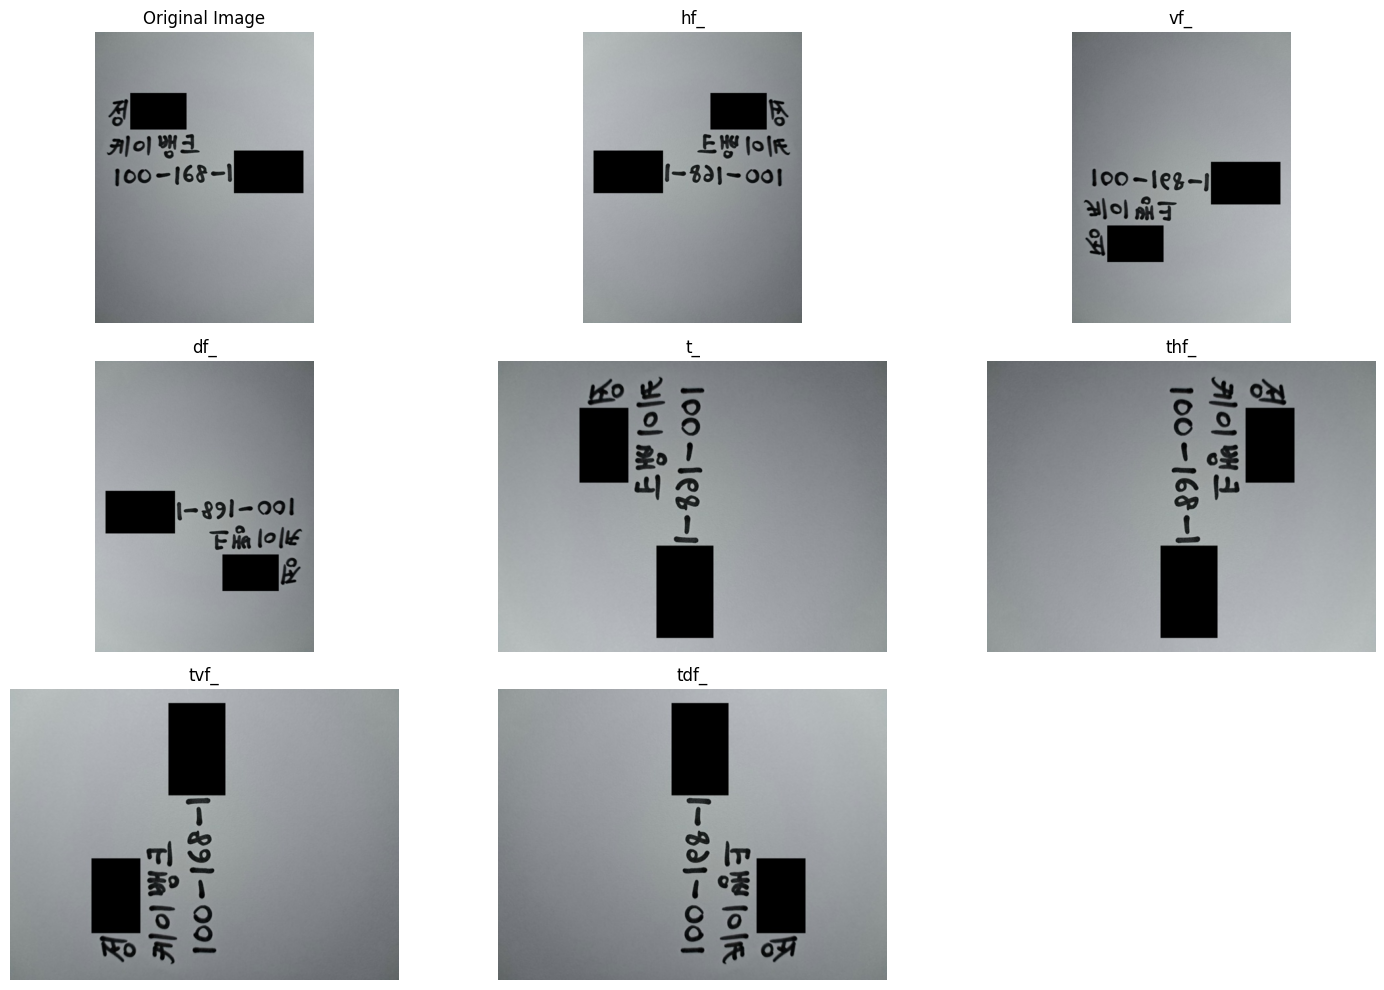

Image augmentation: 100%|██████████| 1570/1570 [00:22<00:00, 69.75it/s]


In [7]:
ids = []
targets = []

# `train_kr_df` DataFrame의 각 행에 대해 반복합니다.
# `itertuples()`는 DataFrame을 튜플 형태로 반복할 수 있게 해줍니다.
for index, ID, target in tqdm(TRAIN_DF.itertuples(), total=TRAIN_DF.shape[0], desc='Image augmentation'):
    # 이미지의 파일 경로를 생성합니다.
    image_path = os.path.join(TRAIN_IMAGE_PATH, ID)
    
    # 이미지 파일을 열고, numpy 배열로 변환합니다.
    image = np.array(Image.open(image_path))
    
    # `noise_rotate` 변환을 사용하여 이미지를 변환합니다.
    # transformed_image = noise_rotate(image=image)['image']

    # `base_aug_types`에 정의된 각 변환에 대해 반복합니다.
    for prefix, aug_function in base_aug_types:
        # 변환 함수를 사용하여 이미지를 변환합니다.
        transformed_image = aug_function(image=image)['image']
        
        # 변환된 이미지의 새로운 ID를 생성합니다.
        new_ID = prefix + ID
        
        # 새로운 ID와 타겟 정보를 리스트에 추가합니다.
        ids.append(new_ID)
        targets.append(target)
        
        # 변환된 이미지를 저장합니다.
        Image.fromarray(transformed_image).save(os.path.join(TRAIN_AUG_IMAGE_PATH, new_ID))

# 변환된 이미지의 ID와 타겟 정보를 담은 DataFrame을 생성합니다.
aug_data = {
    'ID': ids,
    'target': targets
}
aug_data = pd.DataFrame(aug_data)

# 원본 DataFrame `train_kr_df`와 증강된 데이터 `aug_data`를 결합하여 새로운 DataFrame `df`를 만듭니다.
df = pd.concat([TRAIN_DF, aug_data])
df.to_csv(TRAIN_AUG_CSV_PATH, index=False)


In [8]:
import os
import shutil

# 원본 폴더와 대상 폴더 경로 설정
source_folder = '/upstage-cv-classification-cv2/data/train'
destination_folder = '/upstage-cv-classification-cv2/data/train_aug'

# 대상 폴더가 없으면 생성
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# train 폴더의 모든 파일에 대해 반복
for filename in os.listdir(source_folder):
    # 파일의 전체 경로
    source_file = os.path.join(source_folder, filename)
    destination_file = os.path.join(destination_folder, filename)
    
    # 파일인 경우에만 복사 (폴더는 제외)
    if os.path.isfile(source_file):
        shutil.copy2(source_file, destination_file)
        print(f"Copied: {filename}")

print("All files have been copied from 'train' to 'train_aug'")

Copied: e8f3120294aca53f.jpg
Copied: 7ab983002722bfdd.jpg
Copied: d26e9455cfbf6083.jpg
Copied: 7dbf8f668b479f2f.jpg
Copied: 134a6165b1e7198b.jpg
Copied: b11635eb655b6717.jpg
Copied: 93e181cc39b50c31.jpg
Copied: 5f58e166f410eae4.jpg
Copied: 66e077b9e126c7cb.jpg
Copied: cb21eaf0f58e325a.jpg
Copied: 562f12548dbd4f46.jpg
Copied: e486affcd2c365ff.jpg
Copied: 9131332143278bbd.jpg
Copied: 590a4befbe2db3cc.jpg
Copied: 008f5911bfda7695.jpg
Copied: 2af50704a985252c.jpg
Copied: 308ffb1480b710bb.jpg
Copied: bfd6d17b01b792f6.jpg
Copied: 80fe3a6b9c2f94d1.jpg
Copied: 0ed0af9895d19304.jpg
Copied: 410664d321327e7f.jpg
Copied: 3e74aa6ae952d1a3.jpg
Copied: 133b0b66418f5992.jpg
Copied: 8786ec88edd5b15b.jpg
Copied: 0583254a73b48ece.jpg
Copied: b709b64897d9233f.jpg
Copied: e8db1707653dc637.jpg
Copied: 62d8b41419418098.jpg
Copied: cee86faf6225599e.jpg
Copied: e1df80668c20548f.jpg
Copied: 356ae63d8d2c9a4b.jpg
Copied: 4c618df68895cc0d.jpg
Copied: da79b432d36e053f.jpg
Copied: 64bfe6bb12a2b19d.jpg
Copied: 317d01